Saving factory_injury_data_3_years.csv to factory_injury_data_3_years.csv


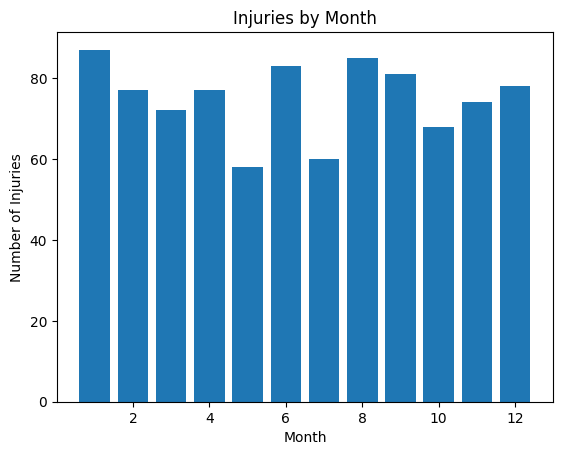

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Install dependencies (if not already)
!pip install pandas scikit-learn joblib

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

# Step 3: Load the CSV data
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))

# Step 4: Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

# Encode categorical variables
le_shift = LabelEncoder()
le_injury = LabelEncoder()
le_incident = LabelEncoder()
le_dept = LabelEncoder()
le_body = LabelEncoder()

df['Shift_enc'] = le_shift.fit_transform(df['Shift'])
df['Injury_enc'] = le_injury.fit_transform(df['Type of Injury'])
df['Incident_enc'] = le_incident.fit_transform(df['Incident Type'])
df['Dept_enc'] = le_dept.fit_transform(df['Department'])
df['Body_enc'] = le_body.fit_transform(df['Body Part'])

# Step 5: Prepare training sets
features = ['Month', 'Day', 'Shift_enc', 'Incident_enc']
X = df[features]

# Target 1: Predict most likely Department
y_dept = df['Dept_enc']
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_dept, test_size=0.2, random_state=42)
model_dept = RandomForestClassifier(n_estimators=100, random_state=42)
model_dept.fit(X_train_d, y_train_d)

# Target 2: Predict most likely Body Part
y_body = df['Body_enc']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_body, test_size=0.2, random_state=42)
model_body = RandomForestClassifier(n_estimators=100, random_state=42)
model_body.fit(X_train_b, y_train_b)

# Step 6: Predict most likely injury-prone month
month_counts = df['Month'].value_counts().sort_index()
plt.bar(month_counts.index, month_counts.values)
plt.xlabel("Month")
plt.ylabel("Number of Injuries")
plt.title("Injuries by Month")
plt.show()

# Step 7: Save trained models
joblib.dump(model_dept, 'department_predictor.pkl')
joblib.dump(model_body, 'body_part_predictor.pkl')
joblib.dump(le_dept, 'dept_encoder.pkl')
joblib.dump(le_body, 'body_encoder.pkl')

# Optional: Download saved models to local machine
files.download('department_predictor.pkl')
files.download('body_part_predictor.pkl')
files.download('dept_encoder.pkl')
files.download('body_encoder.pkl')

In [ ]:
# prompt: Predict injury on September of upcoming month as in which department and what body part

# Step 8: Make Predictions for September of the upcoming month

# Assume 'upcoming_month' is an integer representing the upcoming month (e.g., 10 for October if we are predicting for September)
# and 'upcoming_year' is an integer representing the upcoming year.
# For September of the upcoming month, let's predict for each day in September.

import datetime

upcoming_year = datetime.datetime.now().year + 1 # Assuming upcoming year is the next year
month_to_predict = 9 # September

# Create a DataFrame for predictions for each day in September
september_days = pd.date_range(start=f'{upcoming_year}-{month_to_predict}-01', end=f'{upcoming_year}-{month_to_predict}-30')
prediction_data = []

# Assuming 'Shift' and 'Incident Type' have common values across the dataset
# We'll use the most frequent values from the training data for prediction
most_frequent_shift = df['Shift'].mode()[0]
most_frequent_incident = df['Incident Type'].mode()[0]

# Encode the most frequent values
most_frequent_shift_enc = le_shift.transform([most_frequent_shift])[0]
most_frequent_incident_enc = le_incident.transform([most_frequent_incident])[0]

for day in september_days:
    prediction_data.append({
        'Month': day.month,
        'Day': day.day,
        'Shift_enc': most_frequent_shift_enc,  # Use the most frequent shift encoding
        'Incident_enc': most_frequent_incident_enc # Use the most frequent incident encoding
    })

predict_df = pd.DataFrame(prediction_data)

# Predict Department
predicted_dept_enc = model_dept.predict(predict_df[features])
predicted_departments = le_dept.inverse_transform(predicted_dept_enc)
predict_df['Predicted_Department'] = predicted_departments

# Predict Body Part
predicted_body_enc = model_body.predict(predict_df[features])
predicted_body_parts = le_body.inverse_transform(predicted_body_enc)
predict_df['Predicted_Body_Part'] = predicted_body_parts

# Display the predictions
print("\nPredicted Injuries for September of the Upcoming Month:")
print(predict_df[['Month', 'Day', 'Predicted_Department', 'Predicted_Body_Part']])

# Analyze the most frequent predicted department and body part in September
most_frequent_predicted_dept = predict_df['Predicted_Department'].mode()[0]
most_frequent_predicted_body = predict_df['Predicted_Body_Part'].mode()[0]

print(f"\nMost frequent predicted Department in September: {most_frequent_predicted_dept}")
print(f"Most frequent predicted Body Part in September: {most_frequent_predicted_body}")


Predicted Injuries for September of the Upcoming Month:
    Month  Day Predicted_Department Predicted_Body_Part
0       9    1            Logistics                Head
1       9    2            Packaging                Head
2       9    3            Packaging                 Arm
3       9    4            Packaging                 Arm
4       9    5            Packaging                Hand
5       9    6           Production                 Arm
6       9    7          Maintenance                 Arm
7       9    8      Quality Control                Hand
8       9    9      Quality Control                Hand
9       9   10      Quality Control                Hand
10      9   11            Packaging                 Leg
11      9   12            Logistics                 Leg
12      9   13           Production                Back
13      9   14           Production                Back
14      9   15      Quality Control                 Eye
15      9   16      Quality Control            

In [ ]:
# prompt: Create neural network with the orginal data and create a neural network model for the above prediction

!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 9: Create and train Neural Network models

# Prepare data for neural network models
# Using the same features and targets as the Random Forest models

# Target 1: Predict most likely Department using Neural Network
y_dept_nn = y_dept # Already encoded from previous steps

# Define the neural network model for Department prediction
model_dept_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_d.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(le_dept.classes_), activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
model_dept_nn.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
                      metrics=['accuracy'])

# Train the neural network model for Department
history_dept_nn = model_dept_nn.fit(X_train_d, y_train_d, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

print("\nNeural Network Model Training (Department Prediction) Completed.")

# Target 2: Predict most likely Body Part using Neural Network
y_body_nn = y_body # Already encoded from previous steps

# Define the neural network model for Body Part prediction
model_body_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_b.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(le_body.classes_), activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
model_body_nn.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train the neural network model for Body Part
history_body_nn = model_body_nn.fit(X_train_b, y_train_b, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

print("Neural Network Model Training (Body Part Prediction) Completed.")

# Optional: Evaluate the Neural Network models on the test data
loss_dept_nn, accuracy_dept_nn = model_dept_nn.evaluate(X_test_d, y_test_d, verbose=0)
print(f"\nNeural Network Department Prediction Test Accuracy: {accuracy_dept_nn:.4f}")

loss_body_nn, accuracy_body_nn = model_body_nn.evaluate(X_test_b, y_test_b, verbose=0)
print(f"Neural Network Body Part Prediction Test Accuracy: {accuracy_body_nn:.4f}")

# Step 10: Make Predictions using the Neural Network models for September

# Use the same predict_df created for Random Forest predictions

# Predict Department using the Neural Network model
predicted_dept_probs_nn = model_dept_nn.predict(predict_df[features])
predicted_dept_enc_nn = np.argmax(predicted_dept_probs_nn, axis=1)
predicted_departments_nn = le_dept.inverse_transform(predicted_dept_enc_nn)
predict_df['Predicted_Department_NN'] = predicted_departments_nn

# Predict Body Part using the Neural Network model
predicted_body_probs_nn = model_body_nn.predict(predict_df[features])
predicted_body_enc_nn = np.argmax(predicted_body_probs_nn, axis=1)
predicted_body_parts_nn = le_body.inverse_transform(predicted_body_enc_nn)
predict_df['Predicted_Body_Part_NN'] = predicted_body_parts_nn

# Display the predictions from the Neural Network models
print("\nPredicted Injuries for September of the Upcoming Month (using Neural Network):")
print(predict_df[['Month', 'Day', 'Predicted_Department_NN', 'Predicted_Body_Part_NN']])

# Analyze the most frequent predicted department and body part in September from NN
most_frequent_predicted_dept_nn = predict_df['Predicted_Department_NN'].mode()[0]
most_frequent_predicted_body_nn = predict_df['Predicted_Body_Part_NN'].mode()[0]

print(f"\nMost frequent predicted Department in September (NN): {most_frequent_predicted_dept_nn}")
print(f"Most frequent predicted Body Part in September (NN): {most_frequent_predicted_body_nn}")

# Optional: Save the trained Neural Network models
model_dept_nn.save('department_predictor_nn.h5')
model_body_nn.save('body_part_predictor_nn.h5')

# Optional: Download saved NN models to local machine
files.download('department_predictor_nn.h5')
files.download('body_part_predictor_nn.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Neural Network Model Training (Department Prediction) Completed.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Model Training (Body Part Prediction) Completed.

Neural Network Department Prediction Test Accuracy: 0.1611
Neural Network Body Part Prediction Test Accuracy: 0.1389
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step



Predicted Injuries for September of the Upcoming Month (using Neural Network):
    Month  Day Predicted_Department_NN Predicted_Body_Part_NN
0       9    1             Maintenance                   Hand
1       9    2               Packaging                   Hand
2       9    3              Production                    Arm
3       9    4              Production                    Arm
4       9    5             Maintenance                    Arm
5       9    6             Maintenance                    Arm
6       9    7             Maintenance                    Arm
7       9    8         Quality Control                    Arm
8       9    9         Quality Control                    Arm
9       9   10         Quality Control                   Hand
10      9   11         Quality Control                   Back
11      9   12         Quality Control                   Back
12      9   13               Packaging                   Back
13      9   14               Packaging              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: H5py read neural network saved

# To load the saved Neural Network models from .h5 files
from tensorflow.keras.models import load_model

# Load the Department predictor NN model
loaded_model_dept_nn = load_model('department_predictor_nn.h5')
print("\nLoaded Neural Network Department Predictor Model:")
loaded_model_dept_nn.summary()

# Load the Body Part predictor NN model
loaded_model_body_nn = load_model('body_part_predictor_nn.h5')
print("\nLoaded Neural Network Body Part Predictor Model:")
loaded_model_body_nn.summary()

# You can now use the loaded models for making predictions:
# Example: Predict department for the first row of predict_df using the loaded model
# first_prediction_input = predict_df[features].iloc[0:1]
# predicted_dept_prob_loaded = loaded_model_dept_nn.predict(first_prediction_input)
# predicted_dept_enc_loaded = np.argmax(predicted_dept_prob_loaded, axis=1)
# predicted_dept_loaded = le_dept.inverse_transform(predicted_dept_enc_loaded)
# print(f"\nPrediction for the first entry using loaded Department NN model: {predicted_dept_loaded[0]}")


Loaded Neural Network Department Predictor Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,567 (10.03 KB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Loaded Neural Network Body Part Predictor Model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,633 (10.29 KB)

 Trainable params: 2,631 (10.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

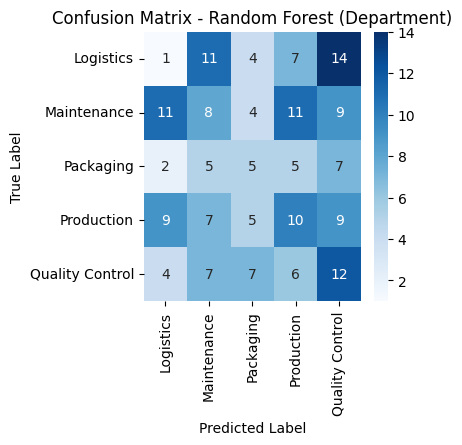

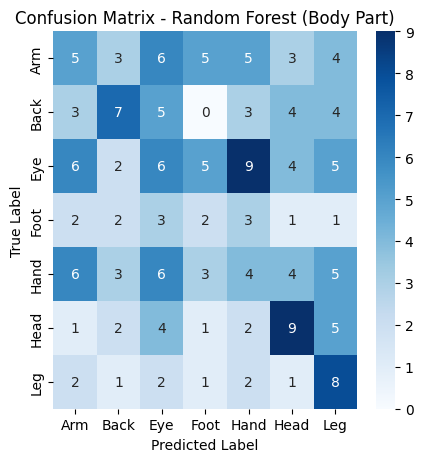

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


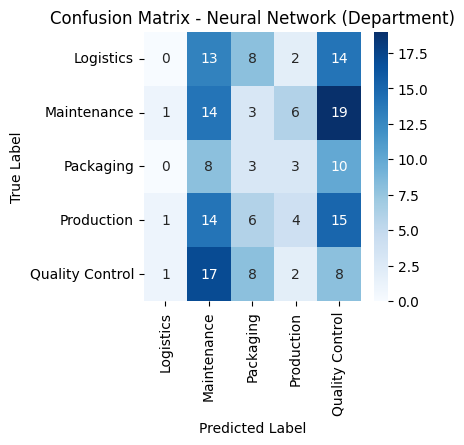

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


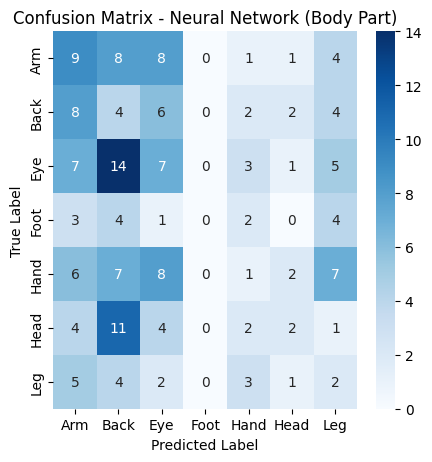

In [ ]:
# prompt: Create confusion matrix of both machine learning model and neural network model

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes)*0.7, len(classes)*0.7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Random Forest Confusion Matrices ---

# Department Prediction (Random Forest)
y_pred_dept_rf = model_dept.predict(X_test_d)
plot_confusion_matrix(y_test_d, y_pred_dept_rf, le_dept.classes_, 'Confusion Matrix - Random Forest (Department)')

# Body Part Prediction (Random Forest)
y_pred_body_rf = model_body.predict(X_test_b)
plot_confusion_matrix(y_test_b, y_pred_body_rf, le_body.classes_, 'Confusion Matrix - Random Forest (Body Part)')

# --- Neural Network Confusion Matrices ---

# Department Prediction (Neural Network)
y_pred_probs_dept_nn = model_dept_nn.predict(X_test_d)
y_pred_dept_nn = np.argmax(y_pred_probs_dept_nn, axis=1)
plot_confusion_matrix(y_test_d, y_pred_dept_nn, le_dept.classes_, 'Confusion Matrix - Neural Network (Department)')

# Body Part Prediction (Neural Network)
y_pred_probs_body_nn = model_body_nn.predict(X_test_b)
y_pred_body_nn = np.argmax(y_pred_probs_body_nn, axis=1)
plot_confusion_matrix(y_test_b, y_pred_body_nn, le_body.classes_, 'Confusion Matrix - Neural Network (Body Part)')


Model plot saved to department_predictor_nn.png


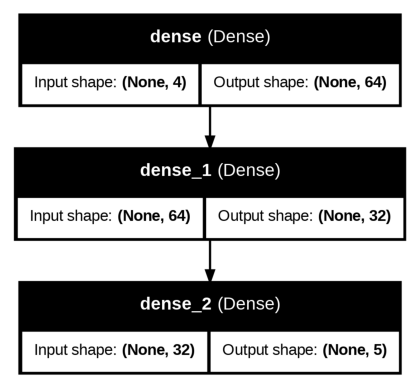


Model plot saved to body_part_predictor_nn.png


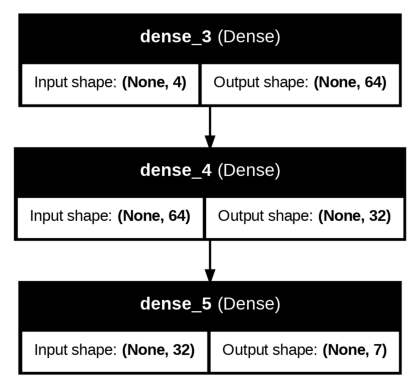

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: Plot model in png print png

!pip install pydot graphviz
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Function to plot and save a Keras model to PNG
def plot_and_save_model(model, filename):
    """
    Plots a Keras model and saves it as a PNG file.

    Args:
        model: The Keras model to plot.
        filename (str): The name of the output PNG file.
    """
    try:
        plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
        print(f"\nModel plot saved to {filename}")
        # Display the image (optional)
        img = plt.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except ImportError:
        print("Please install pydot and graphviz to plot the model:")
        print("!pip install pydot graphviz")
    except Exception as e:
        print(f"Error plotting or saving model {filename}: {e}")

# Assuming model_dept_nn and model_body_nn are already trained Keras models

# Plot and save the Department NN model
plot_and_save_model(model_dept_nn, 'department_predictor_nn.png')

# Plot and save the Body Part NN model
plot_and_save_model(model_body_nn, 'body_part_predictor_nn.png')

# Optional: Download the generated PNG files
from google.colab import files
files.download('department_predictor_nn.png')
files.download('body_part_predictor_nn.png')
